# K-fold Cross-Validation <a name="head"></a>

This tutorial will go through setting up a function to perform k-fold cross-validation. This is a very common way to assess the performance of a model.

## Table of Contents
[(Back to top)](#head)

-   [Data Setup](#data-setup)
-   [Subset Generation](#subset-generation)
-   [Prediction Setup](#prediction-setup)
-   [Cross-valisation Setup](#cross-validation-setup)
-   [Prediction Analysis](#prediction-analysis)
-   [Conclusions](#conclusions)

## Data Setup <a name="data-setup"></a>
[(Back to top)](#head)

First, we need to import some functions.

In [1]:
# Comment out this line when exported to .py file
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from ase.ga.data import DataConnection

from catlearn.featurize.setup import FeatureGenerator
from catlearn.cross_validation import k_fold
from catlearn.cross_validation.k_fold_cv import write_split, read_split
from catlearn.regression import RidgeRegression, GaussianProcess
from catlearn.regression.cost_function import get_error

Then we can load some data. There is some pre-generated data in an ase-db so first, the atoms objects are loaded into a list. Then they are fed through a feature generator.

In [2]:
# Connect ase atoms database.
gadb = DataConnection('../../data/gadb.db')

# Get all relaxed candidates from the db file.
all_cand = gadb.get_all_relaxed_candidates(use_extinct=False)
print('Loaded {} atoms objects'.format(len(all_cand)))

# Generate the feature matrix.
fgen = FeatureGenerator()
features = fgen.return_vec(all_cand, [fgen.eigenspectrum_vec])
print('Generated {} feature matrix'.format(np.shape(features)))

# Get the target values.
targets = []
for a in all_cand:
    targets.append(a.info['key_value_pairs']['raw_score'])
print('Generated {} target vector'.format(np.shape(targets)))

  1%|          | 11/1072 [00:00<00:09, 109.18it/s]

Loaded 1072 atoms objects


100%|██████████| 1072/1072 [00:08<00:00, 121.06it/s]

Generated (1072, 147) feature matrix
Generated (1072,) target vector


It is important to note that the `all_cand` variable is simply a list of atoms objects. There are no constraints on how this should be set up, the above example is just a succinct method for generating the list.

## Subset Generation <a name="subset-generation"></a>
[(Back to top)](#head)

Once the data has been generated, it is necessary to split the training features and training targets into k-folds. This can be achieved using a function in CatLearn with the `k_fold` function. Here is is possible to provide feature data, target data and the number of folds.

In [3]:
fsplit, tsplit = k_fold(features=features, targets=targets, nsplit=5)

print('k_fold has generated {} subsets of features.'.format(len(fsplit)))
for index in range(len(fsplit)):
    print('    subset {0} has shape {1}'.format(index, np.shape(fsplit[index])))
    
print('\nk_fold has generated {} subsets of targets.'.format(len(tsplit)))
for index in range(len(tsplit)):
    print('    subset {0} has shape {1}'.format(index, np.shape(tsplit[index])))

k_fold has generated 5 subsets of features.
    subset 0 has shape (215, 147)
    subset 1 has shape (215, 147)
    subset 2 has shape (214, 147)
    subset 3 has shape (214, 147)
    subset 4 has shape (214, 147)

k_fold has generated 5 subsets of targets.
    subset 0 has shape (215,)
    subset 1 has shape (215,)
    subset 2 has shape (214,)
    subset 3 has shape (214,)
    subset 4 has shape (214,)


If we are interested in saving this data, it is possible to write a JSON or pickle file. This is achieved using the following functions to write and read the data.

In [4]:
# First write a json file.
write_split(features=fsplit, targets=tsplit, fname='kfoldSave', fformat='json')

# Read data back in.
fread, tread = read_split(fname='kfoldSave', fformat='json')

Once the data has been divided into subsets, it is possible to analyze the models being trained.

## Prediction Setup <a name="prediction-setup"></a>
[(Back to top)](#head)

Once the data split has been generated we can define a prediction function. This will be called on all subsets of data and is expected to take test and training features and targets. The function then returns a dictionary with `{'result': list, 'size': list}`. The `result` is an average error and the `size` will be the number of training data points. The following provides an example with Gaussian process predictions.

In [5]:
def gp_predict(train_features, train_targets, test_features, test_targets):
    """Function to perform the GP predictions."""
    data = {}
    
    kdict = [
        {'type': 'gaussian', 'width': 1., 'scaling': 1., 'dimension': 'single'}
        ]
    gp = GaussianProcess(train_fp=train_features, train_target=train_targets,
                         kernel_list=kdict, regularization=1e-2,
                         optimize_hyperparameters=True, scale_data=True)

    pred = gp.predict(test_fp=test_features)

    data['result'] = get_error(pred['prediction'],
                               test_targets)['rmse_average']
    data['size'] = len(train_targets)

    return data

## Cross-validation Setup <a name="cross-validation-setup"></a>
[(Back to top)](#head)

Next, we can run the cross-validation on the generated data. In order to allow for flexible storage of large numbers of data subsets, we convert the feature and target arrays to a simple db format. This is performed with the `todb()` function. After this, we split up the db index to define the subsets of data with the `split_index()` function. In this case, the maximum amount of data considered in 1000 data points and the smallest set of data will contain a minimum of 50 data points.

In [6]:
x, y = list(range(len(fsplit))), []
for index in x:
    fcopy, tcopy = fsplit.copy(), tsplit.copy()
    ftest, ttest = fcopy.pop(index), tcopy.pop(index)
    
    fcopy = np.concatenate(fcopy, axis=0)
    tcopy = np.concatenate(tcopy, axis=0)
    
    y.append(gp_predict(fcopy, tcopy, ftest, ttest)['result'])

## Prediction Analysis <a name="prediction-analysis"></a>
[(Back to top)](#head)

We can then visualize how the error varies acorss the different subsets of data.

Averaged error: 0.14651725436449345


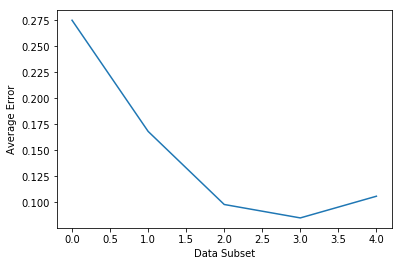

In [7]:
plt.figure(0)
plt.plot(x, y, '-')
plt.xlabel('Data Subset')
plt.ylabel('Average Error')

print('Averaged error: {}'.format(sum(y)/float(len(y))))

We can then clean up the directory and remove saved files.

In [8]:
# Remove output.
os.remove('kfoldSave.json')

In [ ]:
plt.show()

## Conclusions <a name="conclusions"></a>
[(Back to top)](#head)

This tutorial has gone through generating a simple set of functions to perform k-fold cross-validation.
